In [193]:
# standard imports
import datetime
import os
import sys

from subprocess import check_output

# third party imports
import matplotlib.pyplot as plt # MATLAB like plotting framework
import numpy as np # linear algebra
import pandas as pd # Data ETL, csv file I/O
import sklearn.metrics as skm

from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# src directory imports
module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.helper_functions import load_dataset, plot_roc, plot_confusion_matrix, CleanTextTransformer

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In this exercise I will begin to model the success of a campaign. I will start with a tradiitional logistic regression model and examine the feature space using the coefficients. Accuracy will be assessed using the scoring function provided by the sklearn module for each model. For binary classification problems such as what we have here, this will be accuracy. The other metrics I will use are Area under the curve (AUC) and the confusion matrix to examine true/false positive/negative rates.

To begin we load the dataset:

In [210]:
df = load_dataset()

In [162]:
df['success'] = (df['state'] == 'successful').astype(int)
test_live = df[df.state == 'live']
df_all = df[df['state'].isin(['successful', 'failed'])]

In [163]:
df_all.head()

,id,photo,name,blurb,goal,pledged,state,slug,disable_communication,country,...,spotlight,urls,source_url,friends,is_starred,is_backing,permissions,success,type,subtype
0,2081133073,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",Dracula: The Kisses... Help Scary Little Girls...,Dracula: The Kisses… is an all-female producti...,8000.0,2507.0,failed,dracula-the-kisses-help-scary-little-girls-fly...,False,GB,...,False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,0,theater,plays
1,262077000,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Historial Women,The Power of Women and Their Contributions to ...,2000.0,19.0,failed,historial-women,False,US,...,False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,0,theater,plays
2,1541121253,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",The Sequel: a comedy with puppets,Our play The Sequel has a 2 week run at The Ca...,500.0,1.0,failed,the-sequel-a-comedy-with-puppets,False,GB,...,False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,0,theater,plays
3,489010822,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Young blind actors have a life-changing opport...,Four blind youth from Los Angeles based Theatr...,15000.0,2095.0,failed,young-blind-actors-have-a-life-changing-opport...,False,US,...,False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,0,theater,plays
4,702028718,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",Drama School Fund,Raising money to send a young Actress to Drama...,10600.0,11.0,failed,drama-school-fund,False,GB,...,False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,0,theater,plays


drop _id_ and other columns not useful in predicting the response variable at campaign creation time.

In [164]:
df_all.drop(['id', 'backers_count', 'pledged', 'usd_pledged'], axis = 1, inplace = True)

From EDA we figured out we wanted to convert unix time series to a datetime series. I will ignore the state_changed_at column and backers count column since this would not be available during campaign creation.

In [165]:
df_all['launched_at'] = pd.to_datetime(df_all['launched_at'],unit='s')
df_all['state_changed_at'] = pd.to_datetime(df_all['state_changed_at'],unit='s')
df_all['created_at'] = pd.to_datetime(df_all['created_at'],unit='s')
df_all['deadline'] = pd.to_datetime(df_all['deadline'],unit='s')

Since we aren't interested in a longitudinal model at this time and are working with panel data, we will not be using these dateime features in the models. Instead we will use the difference in these datetime columns as continuous numeric values. 

In [166]:
df_all['launched-created'] = (df_all.launched_at - df_all.created_at).dt.components.days
df_all['deadline-launched'] = (df_all.deadline - df_all.launched_at).dt.components.days

In [167]:
datetime_columns = ['launched_at', 'created_at', 'deadline', 'state_changed_at']

In [9]:
baseline_features = df_all.describe().columns
baseline_features = baseline_features.tolist()
baseline_features = baseline_features[:]
del baseline_features[baseline_features.index('success')]
baseline_features

['goal', 'static_usd_rate', 'launched-created', 'deadline-launched']

In [16]:
X = df_all.loc[:, baseline_features]
y = df_all.success.astype('float')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=67)

## First Model: Logistic Regression

In [25]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [26]:
lr.score(X_test,y_test)

0.60199322813518175

In [29]:
v_probs = lr.predict_proba(X_test)[:, 1]

/Users/gmacmillan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


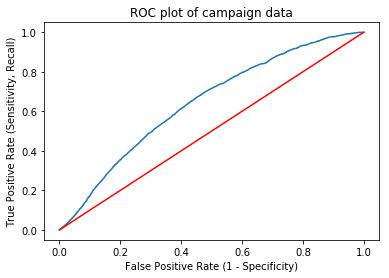

In [35]:
plot_roc(v_probs, y_test, "ROC plot of campaign data", 
         "False Positive Rate (1 - Specificity)", "True Positive Rate (Sensitivity, Recall)")

In [36]:
skm.roc_auc_score(y_test, lr.predict(X_test))

0.5943849436302524

Pretty terrible area under the curve.

In [37]:
pd.crosstab(y_test, lr.predict(X_test))

col_0,0.0,1.0
success,,
0.0,11947,4658
1.0,7802,6899


[[11947  4658]
 [ 7802  6899]]


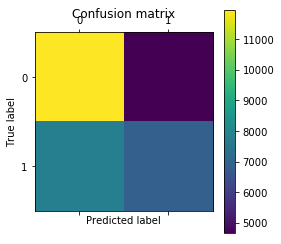

In [40]:
plot_confusion_matrix(lr, X_test, y_test)

What are the beta coefficients?

In [46]:
for name, coef in zip(baseline_features, lr.coef_[0]):
    print("%s: %.6f" % (name, coef))

goal: -0.000010
static_usd_rate: 0.000019
launched-created: 0.001364
deadline-launched: 0.000265


Compute the change in odds ratio from a one unit change in each feature:

In [49]:
for i, coef in enumerate(lr.coef_[0]):
    print("beta%d: %.5f" % (i + 1, np.exp(coef)))

beta1: 0.99999
beta2: 1.00002
beta3: 1.00137
beta4: 1.00027


Example effects of the input variables according to this model are as follows:
* Decreasing the goal amount by 1 unit increases the chance of a succesful campaign by a factor of 1/0.99999=1.00001...

* Increasing the time between launch and creation by 1 unit increases the chance of getting in by a factor of 1.00137.



This is a pretty crappy model maybe we can make it better by using feature engineering

## Feature Engineering

In [53]:
cleaner = CleanTextTransformer()

In [71]:
df_all['name'] = cleaner.fit_transform(df_all['name'])
df_all['blurb'] = cleaner.fit_transform(df_all['blurb'])

In [73]:
df_all['name_len'] = df_all.name.apply(lambda x: len(x))
df_all['blurb_len'] = df_all.blurb.apply(lambda x: len(x))

In [102]:
features1 = df_all.describe().columns
features1 = features1.tolist()
features1 = features1[:]
del features1[features1.index('success')]
features1

['goal',
 'static_usd_rate',
 'launched-created',
 'deadline-launched',
 'name_len',
 'blurb_len']

In [109]:
X = df_all.loc[:, features1]
y = df_all.success.astype('int')

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=67)

In [111]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [112]:
lr.score(X_test,y_test)

0.5977448412444899

It definitely just got a little worse... hmmm let's see how a random forest does.

## Second Model: Random Forest

In [113]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [114]:
rfc.score(X_test, y_test)

0.63189165016290805

This model appear to do a bit better than standard logistic regression

## More Feature Engineering..

In [168]:
df_all['launched_at_hr'] = df_all['launched_at'].apply(lambda x: x.hour) + 1

In [169]:
df_all['deadline_hr'] = df_all['deadline'].apply(lambda x: x.hour) + 1

In [170]:
df_all['created_at_hr'] = df_all['created_at'].apply(lambda x: x.hour) + 1

In [171]:
df_all['type'] = df_all['category'].apply(lambda x: x['slug'].split('/')[0])
# df_all['subtype'] = df_all['category'].apply(lambda x: x['slug'].split('/')[1])

In [172]:
type_dict = {k: v for v, k in enumerate(df_all.type.unique().tolist())}
type_dict_inv = {v: k for k, v in type_dict.items()}

In [173]:
def encode_type(X):
    return X.apply(lambda x: type_dict[x])

In [174]:
df_all['type'] = encode_type(df_all['type'])

Encode categorical integer features using a one-hot aka one-of-K scheme.

In [175]:
features2 = df_all.describe().columns
features2 = features2.tolist()
features2 = features2[:]
del features2[features2.index('success')]
features2

['goal',
 'static_usd_rate',
 'type',
 'launched-created',
 'deadline-launched',
 'launched_at_hr',
 'deadline_hr',
 'created_at_hr']

In [199]:
X = df_all.loc[:, features2]
y = df_all.success.astype('int')
X = pd.get_dummies(X, columns=['type', 'launched_at_hr', 'deadline_hr', 'created_at_hr'])

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=67)

In [201]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [202]:
rfc.score(X_test, y_test)

0.68766370663770526

In [203]:
v_probs = rfc.predict_proba(X_test)[:, 1]

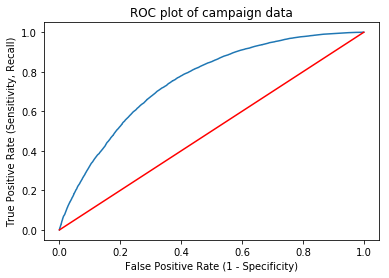

In [204]:
plot_roc(v_probs, y_test, "ROC plot of campaign data", 
         "False Positive Rate (1 - Specificity)", "True Positive Rate (Sensitivity, Recall)")

In [206]:
skm.roc_auc_score(y_test, rfc.predict(X_test))

0.68682389039159197

In [207]:
pd.crosstab(y_test, rfc.predict(X_test))

col_0,0,1
success,,
0,11634,4971
1,4807,9894


Nearing 70% auc. Let's try another model.

## Third Model: Gradient Boosting Classification Trees

In [209]:
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=8, subsample=0.5, 
                                 max_features='auto', learning_rate=0.05)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=0.5, verbose=0, warm_start=False)

In [211]:
gbc.score(X_test,y_test)

0.70120743627419668

This model is better than our Random Forest! I bet with grid search, I could find even more improvements. Unfortunately this model took a while to train and as I am under a time constraint a will leave it like this for now.

In [212]:
pd.crosstab(y_test, gbc.predict(X_test))

col_0,0,1
success,,
0,11539,5066
1,4288,10413


In [213]:
v_probs = gbc.predict_proba(X_test)[:, 1]

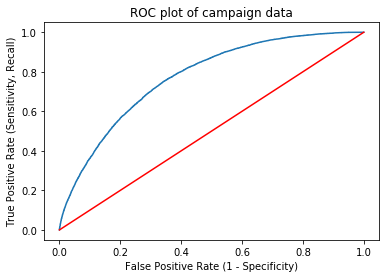

In [215]:
plot_roc(v_probs, y_test, "ROC plot of campaign data", 
         "False Positive Rate (1 - Specificity)", "True Positive Rate (Sensitivity, Recall)")